In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

# 딥드림

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 8장 2절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

[...]

## 케라스 딥드림 구현

ImageNet에서 훈련한 컨브넷을 가지고 시작하겠습니다. 케라스에는 이렇게 사용할 수 있는 컨브넷이 많습니다. VGG16, VGG19, Xception, ResNet50 등입니다. 이 중에 어느 것을 사용해도 딥드림을 구현할 수 있습니다. 당연히 어떤 컨브넷을 선택했느냐에 따라 시각화에 영향을 미칩니다. 각 컨브넷 구조가 학습한 특성이 다르기 때문입니다. 원래 딥드림에서 사용한 컨브넷은 인셉션 모델입니다. 실제로 인셉션이 멋진 딥드림 이미지를 잘 만듭니다. 여기에서도 케라스의 인셉션 V3 모델을 사용하겠습니다.

In [2]:
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

그 다음 손실을 계산합니다. 경사 상승법으로 최대화할 값입니다. 5장 필터 시각화에서 특정 층의 필터 값을 최대화했습니다. 여기에서는 여러 층에 있는 모든 필터 활성화를 동시에 최대화합니다. 특별히 상위 층에 있는 활성화의 L2 노름에 대한 가중치 합을 최대화하겠습니다. 정확히 어떤 층들을 선택했는지에 따라 (당연히 최종 손실에 기여한 정도에 따라) 만들어 내는 시각 요소에 큰 영향을 미칩니다. 어떤 층을 선택할지 파라미터로 손쉽게 바꿀 수 있어야 좋습니다. 하위 층은 기하학적인 패턴을 만들고 상위 층은 ImageNet에 있는 클래스로 보이는 시각 요소를 만듭니다(예를 들어 새나 강아지). 먼저 임의로 네 개의 층을 선택해 보겠습니다. 나중에 다른 설정을 다양하게 시도해 보는 것이 좋습니다:

In [3]:
# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

이제 손실 텐서를 정의하겠습니다. 위에서 선택한 층의 활성화에 대한 L2 노름의 가중치 합입니다.

In [4]:
# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

그 다음 경사 상승법 과정을 준비합니다:

In [5]:
# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

마지막으로 진짜 딥드림 알고리즘입니다.

먼저 이미지를 처리하기 위한 스케일(옥타브라고도 부릅니다) 리스트를 정의합니다. 스케일은 이전 스케일보다 1.4배 큽니다(40% 증가합니다). 작은 이미지로 시작해서 점점 크기를 키웁니다:

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

가장 작은 것에서 가장 큰 스케일까지 연속적인 각 단계에서 정의한 손실이 최대화되도록 경사 상승법을 수행합니다. 경상 상승법이 실행된 후 이미지 크기를 40% 증가시킵니다.

스케일을 연속적으로 증가시키면서 (점점 뭉개지거나 픽셀 경계가 나타나므로) 이미지 상세를 많이 잃지 않도록 간단한 기교를 사용합니다. 스케일을 늘린 후 이미지에 손실된 디테일을 재주입합니다. 원본 이미지가 크기를 늘렸을 때 어땠는지 알기 때문에 가능합니다. 작은 이미지 크기 S와 큰 이미지 크기 L이 주어지면 크기 L로 변경된 원본 이미지와 크기 S로 변경된 원본 이미지 사이의 차이를 계산합니다. 이 차이가 S에서 L로 변경되었을 때 잃어버린 디테일입니다.

이 코드는 다음에 나오는 유틸리티 함수를 사용합니다. 넘파이 배열 기반의 함수이며 이름으로 역할을 알 수 있습니다. 이 함수를 사용하려면 싸이파이를 설치해야 합니다.

In [6]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = './datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./datasets/final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.65961766
... 1 번째 손실 : 1.016783
... 2 번째 손실 : 1.4680852
... 3 번째 손실 : 2.004862
... 4 번째 손실 : 2.6123784
... 5 번째 손실 : 3.0969973
... 6 번째 손실 : 3.5764883
... 7 번째 손실 : 4.034301
... 8 번째 손실 : 4.4491405
... 9 번째 손실 : 4.8765335
... 10 번째 손실 : 5.2938876
... 11 번째 손실 : 5.646536
... 12 번째 손실 : 6.11348
... 13 번째 손실 : 6.424691
... 14 번째 손실 : 6.835371
... 15 번째 손실 : 7.2653975
... 16 번째 손실 : 7.5840755
... 17 번째 손실 : 7.9728403
... 18 번째 손실 : 8.411912
... 19 번째 손실 : 8.694711
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.2222612
... 1 번째 손실 : 3.61893
... 2 번째 손실 : 4.6622696
... 3 번째 손실 : 5.579642
... 4 번째 손실 : 6.4559994
... 5 번째 손실 : 7.2176023
... 6 번째 손실 : 7.949854
... 7 번째 손실 : 8.627567
... 8 번째 손실 : 9.291845
... 9 번째 손실 : 9.939694
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3350706
... 1 번째 손실 : 3.563632
... 2 번째 손실 : 4.6566796
... 3 번째 손실 : 5.724718
... 4 번째 손실 : 6.7157297
... 5 번째 손실 : 7.68983
... 6 번째 손실 : 8.59963
... 7 번째 손실 : 9.600114


In [8]:
from matplotlib import pyplot as plt

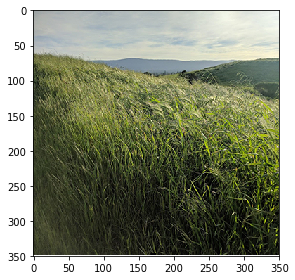

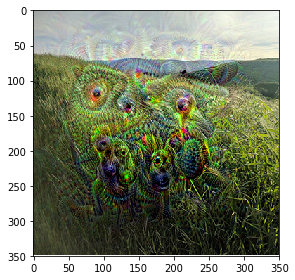

In [9]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()